<a href="https://colab.research.google.com/github/SridharAppusamy/sentiment-analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
#reference Link :https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten , LSTM
from keras.layers import GlobalMaxPooling1D ,Conv1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [5]:
embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/August Preparation 2023/20-Deep Learning/glove.6B.100d.txt', encoding="utf8")

In [18]:
for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [22]:
movie_reviews = pd.read_csv("/content/drive/MyDrive/August Preparation 2023/20-Deep Learning/IMDB Dataset.csv")

movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [23]:
movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

<Axes: xlabel='sentiment', ylabel='count'>

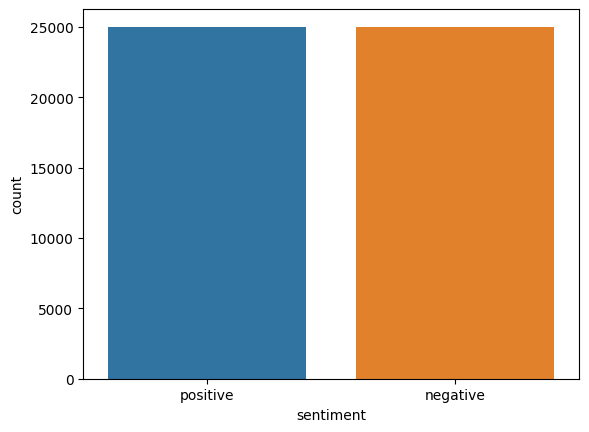

In [25]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [28]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [27]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [29]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [30]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))



In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Preparing the Embedding Layer**

In [34]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [38]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

**Text Classification with Simple Neural Network**

In [43]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [44]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9254700   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [45]:
history = model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2)

Epoch 1/2
250/250 [==============================] - 2s 4ms/step - loss: 0.6931 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.4984
Epoch 2/2
250/250 [==============================] - 1s 2ms/step - loss: 0.6920 - acc: 0.5034 - val_loss: 0.6935 - val_acc: 0.5017


In [46]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 0s 1ms/step - loss: 0.6933 - acc: 0.5062


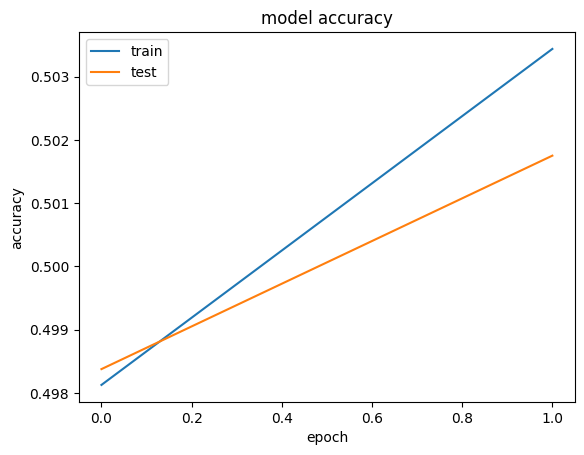

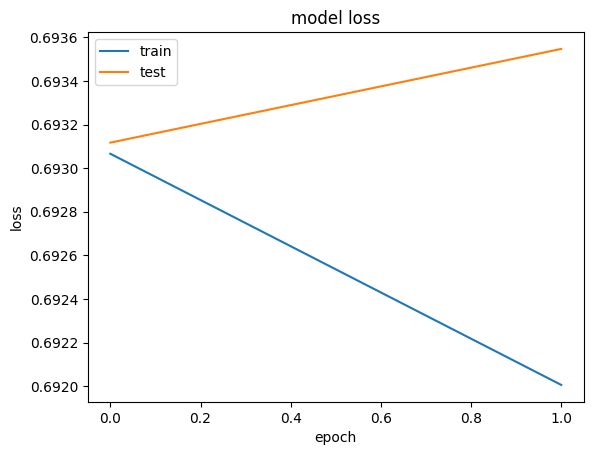

In [49]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**Text Classification with a Convolutional Neural Network**

In [52]:
'''Convolutional neural networks have been found to work well with text data as well.
Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data'''

model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [53]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [54]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 22s 84ms/step - loss: 0.6934 - acc: 0.4985 - val_loss: 0.6928 - val_acc: 0.4999
Epoch 2/6
250/250 [==============================] - 18s 74ms/step - loss: 0.6937 - acc: 0.5027 - val_loss: 0.6927 - val_acc: 0.5033
Epoch 3/6
250/250 [==============================] - 19s 74ms/step - loss: 0.6930 - acc: 0.4974 - val_loss: 0.6933 - val_acc: 0.5029
Epoch 4/6
250/250 [==============================] - 18s 72ms/step - loss: 0.6930 - acc: 0.4963 - val_loss: 0.6926 - val_acc: 0.4999
Epoch 5/6
250/250 [==============================] - 16s 63ms/step - loss: 0.6929 - acc: 0.4997 - val_loss: 0.6925 - val_acc: 0.5004
Epoch 6/6
313/313 [==============================] - 3s 9ms/step - loss: 0.6923 - acc: 0.5079


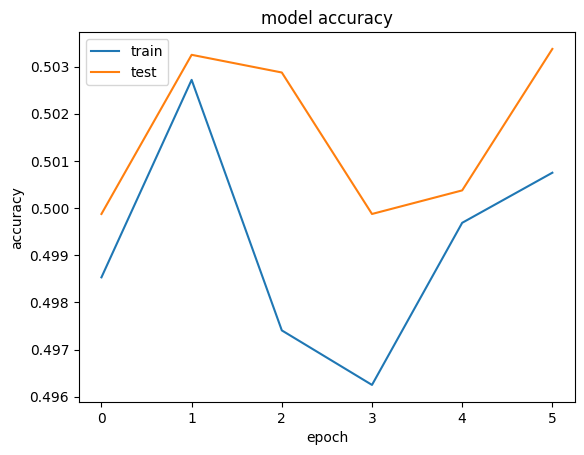

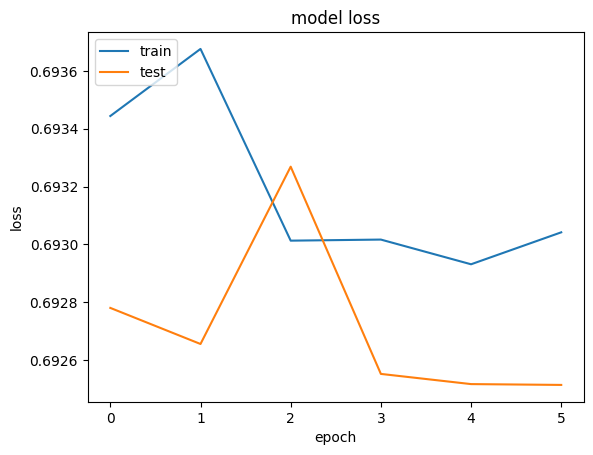

In [55]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

** Text Classification with Recurrent Neural Network (LSTM)**

In [57]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [58]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [59]:
history = model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/2
250/250 [==============================] - 55s 214ms/step - loss: 0.6932 - acc: 0.4991 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/2
313/313 [==============================] - 11s 34ms/step - loss: 0.6930 - acc: 0.5048


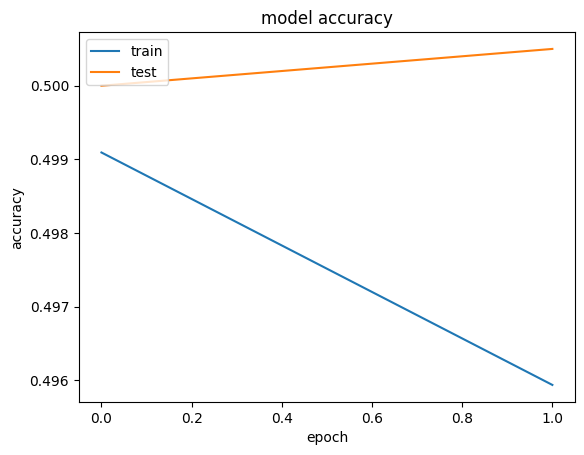

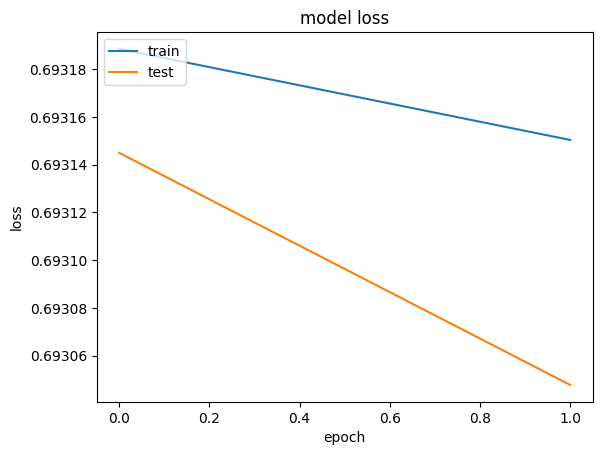

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**Making Predictions on Single Instance**

In [61]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [62]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

1/1 [==============================] - 0s 301ms/step


array([[0.5001729]], dtype=float32)